## Test notebook for Data Management Acceptance Test Campaign 1
This test will be executed on the Rubin Science Platform Notebook Aspect at the Interim Data Facility, initialized with Science Pipelines release w_2022_32.

### Test case LVV-T84: Verify implementation of Bias Residual Image

Verify that DMS can construct a bias residual image that corrects for temporally-stable bias structures.
Verify that DMS can do this on demand.

In [1]:
from lsst.daf.butler import Butler

import matplotlib.pyplot as plt
import numpy as np
import os
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.obs.lsst as obs_lsst

#### Instantiate the Butler pointing to some HSC data:

In [2]:
repo = '/sdf/group/rubin/repo/main'
collection = 'HSC/runs/RC2/w_2022_28/DM-35609'
butler = Butler(repo, collections=collection)

#### Select a DataId for a single visit

In [3]:
dataId = {'instrument': 'HSC', 'detector': 42, 'visit': 30482, 'exposure':30482, 'band':'i'}

In [4]:
raw = butler.get('raw', dataId=dataId)
bias = butler.get('bias', dataId=dataId)

#### Set up plotting defaults:

In [10]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Plot the bias image:

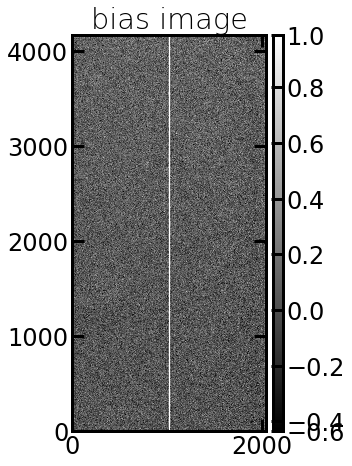

In [11]:
fig, ax = plt.subplots(1, 1)

display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(bias.image)
plt.title("bias image")

plt.tight_layout()
plt.show()

That looks like a bias (i.e., an image consisting mostly of noise).

#### Configure the IsrTask with most corrections disabled.

Note that the `.run` method of `IsrTask` requires the detector number and a camera object to be passed.

In [7]:
isr_config = IsrTask.ConfigClass()
isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doLinearize=False
isr = IsrTask(config=isr_config)
result = isr.run(raw, bias=bias,
                 detectorNum=raw.detector.getId(),
                 camera=obs_lsst.LsstCamImSim.getCamera()
                )

No rough magnitude zero point defined for filter HSC-I.


#### Examine the statistical properties of the bias, raw, and bias-subtracted image:

In [8]:
print('  image       median     stddev    (of image pixel values)')
print('bias:       ', np.nanmedian(bias.image.array), np.nanstd(bias.image.array))
print('raw:        ', np.nanmedian(raw.image.array), np.nanstd(raw.image.array))
print('after bias: ', np.nanmedian(result.outputExposure.image.array), np.nanstd(result.outputExposure.image.array))

  image       median     stddev    (of image pixel values)
bias:        0.07311707 0.23739594
raw:         8130.0 2496.6898982587295
after bias:  6802.6895 895.51544


#### Display the raw image before bias correction and after:

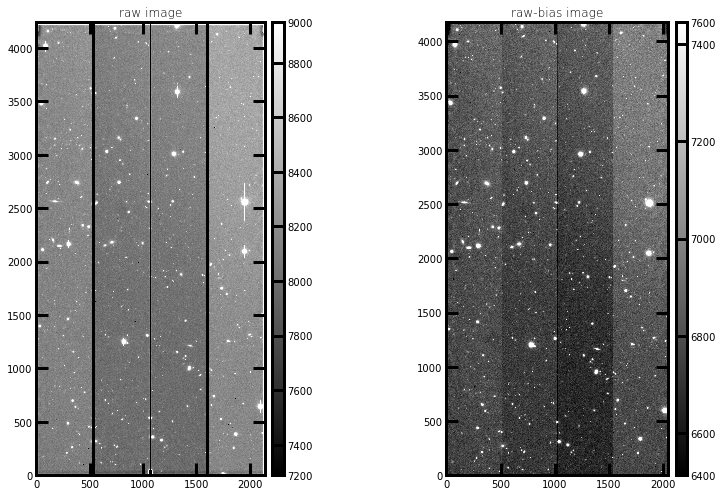

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(raw.image)
plt.title("raw image")

plt.sca(ax[1])
#display1 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(result.outputExposure.image)
plt.title("raw-bias image")

plt.tight_layout()
plt.show()

The bias-subtracted image indeed has a lower overall count level, but more importantly has less noise than the original. We have thus verified the ability to apply the bias correction on demand.